In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [3]:
content_path = tf.keras.utils.get_file(
  'content.jpg',
  "C:/Users/asus/Downloads/cover.jpeg")
style_path = tf.keras.utils.get_file(
  'style.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [5]:
def deprocess(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [6]:
def display_image(image):
    
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

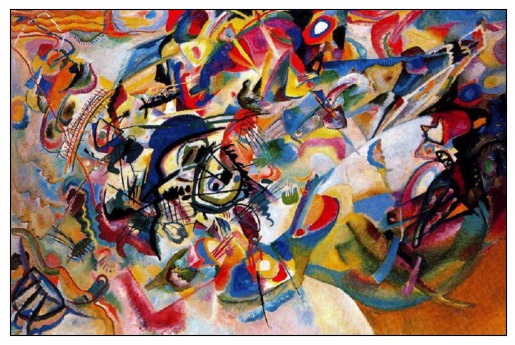

In [7]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)
 
# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)

In [8]:
model = VGG19(
    include_top=False,
    weights='imagenet'
)

model.trainable = False

In [9]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [11]:
content_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [12]:
style_layers = ['block1_conv1','block3_conv1','block5_conv1']

style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

In [13]:
style_models

# Content Loss

In [14]:
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated) 
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

In [15]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [16]:
weight_of_layer = 1. / len(style_models)

In [17]:
weight_of_layer

0.3333333333333333

# Style Loss

In [18]:
def style_cost(style, generated):
    J_style = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        content_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += content_cost * weight_of_layer
 
    return J_style

In [19]:
def content_cost(style, generated):
    J_content = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        content_cost = tf.reduce_mean(tf.square(GS - GG))
        J_content += content_cost * weight_of_layer
 
    return J_content

In [20]:
import time

In [21]:
generated_images = []
 
def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)
 
    opt = tf.keras.optimizers.Adam(learning_rate=7)
 
    best_cost = math.inf
    best_image = None
    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()
        with tf.GradientTape() as tape:
            J_content = content_cost(style, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
 
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
 
        end_time_cpu = time.process_time()  
        end_time_wall = time.time()  
        cpu_time = end_time_cpu - start_time_cpu  
        wall_time = end_time_wall - start_time_wall  
 
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
 
        print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
          int(cpu_time * 1e6),
          int(( end_time_cpu - start_time_cpu) * 1e9),
          int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
             )
         
        print("Wall time: {:.2f} µs".format(wall_time * 1e6))
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())
 
    return best_image

In [ ]:
final_img = training_loop(content_path, style_path)

In [ ]:
plt.figure(figsize=(12, 12))
 
for i in range(10):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i+39])
plt.show()
 
display_image(final_img)